In [97]:
#   +-+-+-+-+-+-+ +-+-+-+-+-+-+-+-+-+-+
#   |L|i|n|e|a|r| |R|e|g|r|e|s|s|i|o|n|
#   +-+-+-+-+-+-+ +-+-+-+-+-+-+-+-+-+-+
#                                                       
#   ________  ________  ________  ________  ___  __    
#  |\   ____\|\   __  \|\   __  \|\   __  \|\  \|\  \   
#  \ \  \___|\ \  \|\  \ \  \|\  \ \  \|\  \ \  \/  /|_ 
#   \ \_____  \ \   ____\ \   __  \ \   _  _\ \   ___  \
#    \|____|\  \ \  \___|\ \  \ \  \ \  \\  \\ \  \\ \  \
#      ____\_\  \ \__\    \ \__\ \__\ \__\\ _\\ \__\\ \__\
#     |\_________\|__|     \|__|\|__|\|__|\|__|\|__| \|__|
#     \|_________| 
#     

In [5]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import requests
from faker import Faker
import ujson as json
import pandas as pd
import requests
from numpy import random 
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from elasticsearch_dsl import Search, DocType, Date, Integer, Keyword, Text
from datetime import datetime
from elasticsearch_dsl.connections import connections
import requests
from random import randint
from pandas.io.json import json_normalize
from pandasticsearch import DataFrame
from pandasticsearch import Select


ES_HOST = 'http://team.ankit.one:9200'
ES_HOST_wo_PORT = 'http://team.ankit.one'
INDEX = "eda_small"
ES_PORT = "9200"
DOC_TYPE="user"
es = Elasticsearch(ES_HOST)
es.indices.put_settings(index=INDEX,
                        body= {"index" : {
                                "max_result_window" : 750000
                              }})


{'acknowledged': True}

In [6]:
#################################################################
###
###  Import SparkSession and LinearRegression from 
###  pyspark.sql and pysparl.ml.regression respectively 
###  
##################################################################

from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression



In [7]:
#################################################################
###
###  SparkSession - a new entry point
###  A SparkSession can be created using a builder pattern. 
###  The builder will automatically reuse an existing SparkContext 
###  if one exists; and create a SparkContext if it does not exist. 
###  
##################################################################

spark = SparkSession.builder.appName("LModel").getOrCreate()

In [8]:
## Create Elasticsearch Query
query = {
            "from" : 0, 
            "size" : 10000,
            "query": {
                        "match_all": {}
                     }
            }
## Import Data
result_dict = es.search(index=INDEX, body=query)


In [334]:
#################################################################
###
###  Importing data into Panda Dataframe first via Pandastactic and than 
###  creating a spark Dataframe.  
###  @Todo create Spark datframe directly from Elastcisearch 
###  
##################################################################


pandas_df = Select.from_dict(result_dict).to_pandas()
pandas_df = pandas_df.set_index(['_id'])
pandas_df.drop(['_index', '_score', '_type'],inplace=True,axis=1,errors='ignore')
pandas_df = pandas_df[(pandas_df['revenue'] > 1000) & (pandas_df['revenue'] < 10000)]
spark_df = spark.createDataFrame(pandas_df)

In [285]:
spark_df.printSchema()


root
 |-- Avg Order Value: double (nullable = true)
 |-- City: string (nullable = true)
 |-- days_since_last_purchase: long (nullable = true)
 |-- discount_percentage: long (nullable = true)
 |-- email_unsubscribe: boolean (nullable = true)
 |-- f_score: long (nullable = true)
 |-- lifecycle: string (nullable = true)
 |-- m_score: long (nullable = true)
 |-- name: string (nullable = true)
 |-- num_of_orders: long (nullable = true)
 |-- r_score: long (nullable = true)
 |-- revenue: long (nullable = true)
 |-- rfm_score: long (nullable = true)
 |-- segments: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- signup_date: string (nullable = true)
 |-- total_discount_revenue: double (nullable = true)



In [286]:
spark_df.count()

6245

In [335]:
#spark_df = spark_df.where((spark_df['num_of_orders'] > 1) & (spark_df['num_of_orders'] <20))
spark_df.count()

2376

In [336]:
# A few things we need to do before Spark can accept the data!
# It needs to be in the form of two columns
# ("label","features")

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [337]:
spark_df.columns

['Avg Order Value',
 'City',
 'days_since_last_purchase',
 'discount_percentage',
 'email_unsubscribe',
 'f_score',
 'lifecycle',
 'm_score',
 'name',
 'num_of_orders',
 'r_score',
 'revenue',
 'rfm_score',
 'segments',
 'signup_date',
 'total_discount_revenue']

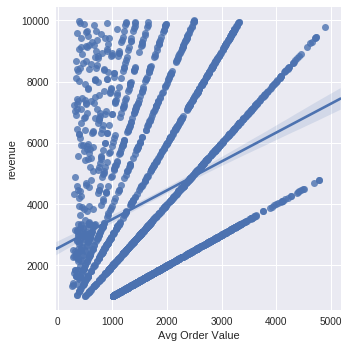

In [338]:
sns.lmplot(y='revenue', x='Avg Order Value', data=pandas_df)
plt.show()

In [361]:
assembler = VectorAssembler(
    inputCols=["m_score", 'Avg Order Value', 'f_score', 'num_of_orders'],
    outputCol="features")

output = assembler.transform(spark_df)

output.select("features").show()

output.show()

final_data = output.select("features",'revenue')

train_data,test_data = final_data.randomSplit([0.7,0.3])

train_data.describe().show()

+--------------------+
|            features|
+--------------------+
|[4.0,2432.0,1.0,2.0]|
|[5.0,3993.5,1.0,2.0]|
|[4.0,1114.75,3.0,...|
|[5.0,2559.3333333...|
|[5.0,1643.0,4.0,6.0]|
|[5.0,2009.0,2.0,3.0]|
|[5.0,2716.5,1.0,2.0]|
|[5.0,614.33333333...|
|[5.0,543.18181818...|
|[5.0,3846.0,1.0,2.0]|
|[5.0,1057.0,3.0,5.0]|
|[4.0,522.33333333...|
|[5.0,3790.5,1.0,2.0]|
|[5.0,2291.0,3.0,4.0]|
|[5.0,3320.5,1.0,2.0]|
|[5.0,3399.0,1.0,2.0]|
|[5.0,2384.3333333...|
|[5.0,2978.5,1.0,2.0]|
|[4.0,1328.0,2.0,3.0]|
|[5.0,3800.5,1.0,2.0]|
+--------------------+
only showing top 20 rows

+------------------+---------+------------------------+-------------------+-----------------+-------+---------------+-------+-----------------+-------------+-------+-------+---------+--------------------+-------------------+----------------------+--------------------+
|   Avg Order Value|     City|days_since_last_purchase|discount_percentage|email_unsubscribe|f_score|      lifecycle|m_score|             name|num_of_ord

In [362]:
train_data.head(1)

[Row(features=DenseVector([2.0, 341.6667, 2.0, 3.0]), revenue=1025)]

In [363]:
test_data.describe().show()

+-------+------------------+
|summary|           revenue|
+-------+------------------+
|  count|               693|
|   mean| 4437.473304473305|
| stddev|2692.0403104122693|
|    min|              1002|
|    max|              9980|
+-------+------------------+



In [364]:
# Create a Linear Regression Model object
lr = LinearRegression(labelCol='revenue')
# Fit the model to the data and call this model lrModel
lrModel = lr.fit(train_data)
# Print the coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [756.676495578,1.5740679364,1283.03559938,8.33725277185] Intercept: -3526.046180429509


In [365]:
test_results = lrModel.evaluate(test_data)
# Interesting results....
test_results.residuals.show(10)

+------------------+
|         residuals|
+------------------+
| 969.1812206045415|
|1411.9178261328589|
|1407.8993505780254|
|1399.8623994683594|
|1386.0847689946459|
|1372.8812064573367|
|1345.9000134463145|
|1339.0111982094577|
|1338.4371302730533|
|1313.1781410712447|
+------------------+
only showing top 10 rows



In [366]:
unlabeled_data = test_data.select('features')
predictions = lrModel.transform(unlabeled_data)
predictions.show()

+--------------------+-------------------+
|            features|         prediction|
+--------------------+-------------------+
| [2.0,601.5,1.0,2.0]| 233.81877939545848|
|[2.0,1032.0,0.0,1.0]|-379.91782613285886|
|[2.0,1039.0,0.0,1.0]| -368.8993505780254|
|[2.0,1053.0,0.0,1.0]| -346.8623994683594|
|[2.0,1077.0,0.0,1.0]|-309.08476899464586|
|[2.0,1100.0,0.0,1.0]| -272.8812064573367|
|[2.0,1147.0,0.0,1.0]|-198.90001344631446|
|[2.0,1159.0,0.0,1.0]| -180.0111982094577|
|[2.0,1160.0,0.0,1.0]| -178.4371302730533|
|[2.0,1204.0,0.0,1.0]|-109.17814107124468|
|[2.0,1228.0,0.0,1.0]| -71.40051059753114|
|[2.0,1241.0,0.0,1.0]| -50.93762742426952|
| [3.0,288.0,4.0,8.0]|  4396.155291677355|
|[3.0,345.25,3.0,4.0]|  3169.886070570413|
|[3.0,408.75,3.0,4.0]| 3269.8393845321134|
|[3.0,533.33333333...| 2174.5691627919805|
|[3.0,539.75,3.0,4.0]|  3476.042284201133|
| [3.0,550.0,2.0,3.0]|  2200.803628398726|
| [3.0,603.0,2.0,3.0]| 2284.2292290281766|
| [3.0,665.5,1.0,2.0]| 1091.2356229029183|
+----------

In [367]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
#print("MSE: {}".format(test_results.meanSquaredError))
print("R^2: {}".format(test_results.r2))

RMSE: 970.7631322199486
R^2: 0.869776137877506


In [368]:
spark_df.select('revenue').describe().show()

+-------+------------------+
|summary|           revenue|
+-------+------------------+
|  count|              2376|
|   mean|4314.5143097643095|
| stddev| 2640.483813842374|
|    min|              1001|
|    max|              9998|
+-------+------------------+



In [348]:
unlabeled_data = train_data.select('features')
unlabeled_data.show(5)

+--------------------+
|            features|
+--------------------+
|[2.0,341.66666666...|
|[2.0,379.66666666...|
|[2.0,388.33333333...|
|[2.0,403.33333333...|
|     [2.0,529.5,1.0]|
+--------------------+
only showing top 5 rows

